In [1]:
import datetime as dt
from datetime import date
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import math
from tqdm import tqdm_notebook

# Data Input, EDA & Preprocessing

## Individual Data Input

In [2]:
price_vol = pd.read_csv('Price & Volume BTC.csv')
tweets = pd.read_csv('Tweets.csv')
funding_rates_1600 = pd.read_csv('Funding Rates BTCUSDT 1600.csv')
funding_rates_0800 = pd.read_csv('Funding Rates BTCUSDT 0800.csv')
funding_rates_0000 = pd.read_csv('Funding Rates BTCUSDT 0000.csv')
google = pd.read_csv('Google.csv')
transactions = pd.read_csv('Transactions.csv')
unique_addresses = pd.read_csv('Unique Addresses.csv')
active_addresses = pd.read_csv('../data/Active Addresses.csv')

## Data Compilation

In [3]:
# get daily ave value for twitter attributes
tweets = tweets.groupby(by="Time").mean()
tweets = tweets.reset_index()

df = pd.merge(price_vol, funding_rates_0000, on=['Time'])
df = pd.merge(df, funding_rates_0800, on=['Time'])
df = pd.merge(df, funding_rates_1600, on=['Time'])
df = pd.merge(df, google, on=['Time'])
df = pd.merge(df, active_addresses, on=['Time'])
df = pd.merge(df, unique_addresses, on=['Time'])
df = pd.merge(df, transactions, on=['Time'])
df = pd.merge(df, tweets, how="outer")
df.head()

,Time,Open,Close,High,Low,Volume,Funding Rate 0000,Funding Rate 0800,Funding Rate 1600,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions,Favorites,Retweets,Compound,Negative,Positive,Neutral
0,2022-03-03,43896.8,42456.3,44088.0,41832.0,324545814.8,0.01%,0.01%,0.01%,13.84,24.08,1011448,701198.0,268244.0,443.269231,79.576923,0.109327,0.036269,0.063731,0.900000
1,2022-03-02,44428.2,43896.9,45367.5,43332.8,340460526.5,0.00%,0.00%,0.01%,15.61,26.33,1091796,731603.0,288657.0,534.200000,90.366667,0.068437,0.037100,0.068967,0.893967
2,2022-03-01,43174.8,44428.2,44966.0,42796.9,444858241.2,-0.01%,0.01%,0.01%,17.67,29.34,1065354,722863.0,280634.0,353.514286,61.028571,0.006329,0.062714,0.070200,0.867114
3,2022-02-28,37706.7,43179.8,44210.4,37446.5,564121052.5,0.00%,-0.02%,-0.01%,16.20,24.83,981066,702483.0,270918.0,332.333333,61.861111,0.135383,0.033806,0.073306,0.892861
4,2022-02-27,39117.3,37706.7,39864.0,36977.4,388368905.7,0.01%,0.01%,0.00%,12.96,21.07,768705,583361.0,211164.0,128.000000,30.000000,0.106867,0.022667,0.055000,0.922333


In [4]:
print("Type of variables: ", "\n", df.dtypes)

Type of variables:  
 Time                        object
Open                       float64
Close                      float64
High                       float64
Low                        float64
Volume                     float64
Funding Rate 0000           object
Funding Rate 0800           object
Funding Rate 1600           object
Bitcoin_SVI                float64
Cryptocurrency_SVI         float64
No. of Active Addresses      int64
No. of Unique Addresses    float64
Transactions               float64
Favorites                  float64
Retweets                   float64
Compound                   float64
Negative                   float64
Positive                   float64
Neutral                    float64
dtype: object


# Preprocessing

## Data Type Transformation

In [5]:
# Transform object type of "Funding Rate 0000", "Funding Rate 0800" and " Funding Rate 1600" to numerical type
df['Funding Rate 0000'] = df['Funding Rate 0000'].map(lambda x: float('nan') if pd.isnull(x) else float(x.replace('%','')))
df['Funding Rate 0800'] = df['Funding Rate 0800'].map(lambda x: float('nan') if pd.isnull(x) else float(x.replace('%','')))
df['Funding Rate 1600'] = df['Funding Rate 1600'].map(lambda x: float('nan') if pd.isnull(x) else float(x.replace('%','')))

df['Month'] = df['Time'].str[:7]
df['Time2'] = df['Time'].map(lambda x: int('nan') if pd.isnull(x) else int(x.replace("-", "")))
df['Month'] = df['Month'].map(lambda x: int('nan') if pd.isnull(x) else int(x.replace("-", "")))
df['FundingRate'] = (df['Funding Rate 1600'] + df['Funding Rate 0800'] + df['Funding Rate 0000'])/3 
df = df.sort_values(by = 'Time', ascending=True).reset_index(drop=True)
df.head(10)


,Time,Open,Close,High,Low,Volume,Funding Rate 0000,Funding Rate 0800,Funding Rate 1600,Bitcoin_SVI,...,Transactions,Favorites,Retweets,Compound,Negative,Positive,Neutral,Month,Time2,FundingRate
0,2020-03-04,8761.2,8750.7,8847.1,8655.7,1.221924e+07,0.01,0.01,0.01,8.64,...,358745.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200304,0.010000
1,2020-03-05,8750.8,9056.9,9153.1,8750.7,1.521845e+07,0.02,0.01,0.02,9.26,...,349529.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200305,0.016667
2,2020-03-06,9056.2,9134.3,9168.7,8989.1,8.833555e+06,0.02,0.02,0.02,8.95,...,338383.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200306,0.020000
3,2020-03-07,9133.9,8889.9,9184.9,8789.8,7.525135e+06,0.04,0.04,0.03,7.10,...,313312.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200307,0.036667
4,2020-03-08,8889.9,8036.5,8889.9,8001.1,1.439716e+07,0.03,0.05,0.05,8.02,...,302694.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200308,0.043333
5,2020-03-09,8035.0,7931.3,8175.2,7636.3,2.070482e+07,0.04,0.01,0.01,16.05,...,348211.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200309,0.020000
6,2020-03-10,7931.4,7895.3,8147.1,7736.9,1.365059e+07,0.01,0.01,0.01,12.34,...,329698.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200310,0.010000
7,2020-03-11,7895.4,7933.2,8000.0,7590.0,1.145017e+07,0.01,0.01,0.01,10.49,...,287492.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200311,0.010000
8,2020-03-12,7933.2,4802.9,7960.4,4448.6,5.524836e+07,0.02,0.01,0.01,22.83,...,349978.0,5.0,2.0,0.0772,0.091,0.1,0.809,202003,20200312,0.013333
9,2020-03-13,4811.8,5576.3,5950.0,3800.0,6.423345e+07,-0.02,-0.02,-0.30,30.86,...,276798.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200313,-0.113333


In [6]:
# Correlation between Close and other variables
df.corr()['Close']

Open                       0.997045
Close                      1.000000
High                       0.998711
Low                        0.998130
Volume                     0.788007
Funding Rate 0000          0.283876
Funding Rate 0800          0.297960
Funding Rate 1600          0.282306
Bitcoin_SVI                0.508730
Cryptocurrency_SVI         0.816407
No. of Active Addresses    0.309198
No. of Unique Addresses    0.326367
Transactions              -0.309340
Favorites                  0.199667
Retweets                   0.157616
Compound                   0.077457
Negative                  -0.006344
Positive                   0.056522
Neutral                   -0.047225
Month                      0.797765
Time2                      0.797769
FundingRate                0.311731
Name: Close, dtype: float64

## Handle Missing Data

In [7]:
# Count missing value
print(df.isna().sum())

Time                         0
Open                         0
Close                        0
High                         0
Low                          0
Volume                       0
Funding Rate 0000            0
Funding Rate 0800            0
Funding Rate 1600            0
Bitcoin_SVI                  0
Cryptocurrency_SVI           0
No. of Active Addresses      0
No. of Unique Addresses      2
Transactions                 0
Favorites                  458
Retweets                   458
Compound                   458
Negative                   458
Positive                   458
Neutral                    458
Month                        0
Time2                        0
FundingRate                  0
dtype: int64


### Monthly Sentiment Analysis

In [8]:
tweets.insert(1, "Month", "NaN")

tweets['Month'] = tweets['Time'].str[:7]
tweets['Month'] = tweets['Month'].map(lambda x: int('nan') if pd.isnull(x) else int(x.replace("-", "")))
tweets.head(10)

,Time,Month,Favorites,Retweets,Compound,Negative,Positive,Neutral
0,2020-03-12,202003,5.0,2.0,0.0772,0.091,0.100,0.809
1,2020-03-17,202003,98.0,96.0,0.4019,0.000,0.114,0.886
2,2020-03-20,202003,125.0,95.0,0.4767,0.000,0.146,0.854
3,2020-03-30,202003,3.0,0.0,0.0803,0.061,0.071,0.869
4,2020-03-31,202003,186.0,142.0,0.6597,0.000,0.278,0.722
5,2020-04-01,202004,171.0,120.0,0.5267,0.061,0.184,0.754
6,2020-04-16,202004,419.0,94.0,0.0000,0.000,0.000,1.000
7,2020-04-22,202004,73.0,18.0,0.3182,0.000,0.084,0.916
8,2020-04-30,202004,994.0,153.0,0.0000,0.000,0.000,1.000
9,2020-05-09,202005,35.0,2.0,0.0000,0.000,0.000,1.000


In [9]:
tweets = tweets.groupby(by="Month").mean()
tweets = tweets.reset_index()

In [10]:
tweets.head(10)

,Month,Favorites,Retweets,Compound,Negative,Positive,Neutral
0,202003,83.400000,67.000000,0.339160,0.030400,0.141800,0.828000
1,202004,414.250000,96.250000,0.211225,0.015250,0.067000,0.917500
2,202005,283.285714,49.142857,0.002414,0.027857,0.057429,0.914571
3,202006,232.000000,155.000000,0.401900,0.000000,0.072000,0.928000
4,202007,303.750000,79.000000,0.227450,0.000000,0.065250,0.934750
5,202008,1103.925926,241.740741,0.379407,0.016296,0.146444,0.837407
6,202009,63.500000,17.000000,0.121117,0.000000,0.035000,0.965000
7,202010,300.000000,50.000000,0.405267,0.000000,0.146000,0.854000
8,202011,254.666667,37.833333,0.117625,0.049250,0.123000,0.827750
9,202012,487.428571,56.571429,0.133693,0.058571,0.110143,0.831286


In [11]:
overall_df = pd.DataFrame(columns = ['Time', 'Month', 'Time2', 'Compound', \
                                 'Close', 'Volume', 'FundingRate', \
                             'Bitcoin_SVI', 'Cryptocurrency_SVI',  'No. of Active Addresses', \
                                 'No. of Unique Addresses', 'Transactions'])

for i, row in df.iterrows():
    if (pd.isna(df.loc[i].at["Favorites"])):
        data = tweets[tweets['Month'] == df.loc[i].at["Month"]]
        new_row = {'Time': df.loc[i].at["Time"],'Time2': df.loc[i].at["Time2"], 'Month': df.loc[i].at["Month"],  'Compound': data.Compound.values[0], \
                    
                 'Close': df.loc[i].at["Close"], 'Volume': df.loc[i].at["Volume"], 'FundingRate': df.loc[i].at["FundingRate"], \
                  'Bitcoin_SVI': df.loc[i].at["Bitcoin_SVI"], \
                   'Cryptocurrency_SVI': df.loc[i].at["Cryptocurrency_SVI"], 'No. of Active Addresses': df.loc[i].at["No. of Active Addresses"], 'No. of Unique Addresses': df.loc[i].at["No. of Unique Addresses"], \
                   'Transactions': df.loc[i].at["Transactions"]}
        overall_df = overall_df.append(new_row, ignore_index=True)
    else:
        new_row = {'Time': df.loc[i].at["Time"], 'Time2': df.loc[i].at["Time2"],'Month': df.loc[i].at["Month"], 'Compound': df.loc[i].at["Compound"], \
                  
                 'Close': df.loc[i].at["Close"],'Volume': df.loc[i].at["Volume"], 'FundingRate': df.loc[i].at["FundingRate"], \
                  'Bitcoin_SVI': df.loc[i].at["Bitcoin_SVI"], \
                   'Cryptocurrency_SVI': df.loc[i].at["Cryptocurrency_SVI"], 'No. of Active Addresses': df.loc[i].at["No. of Active Addresses"], 'No. of Unique Addresses': df.loc[i].at["No. of Unique Addresses"], \
                   'Transactions': df.loc[i].at["Transactions"]}
        overall_df = overall_df.append(new_row, ignore_index=True)


/var/folders/t1/pxny3xn56cd89t4tpk4s00vc0000gn/T/ipykernel_5081/710371745.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(new_row, ignore_index=True)
/var/folders/t1/pxny3xn56cd89t4tpk4s00vc0000gn/T/ipykernel_5081/710371745.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(new_row, ignore_index=True)
/var/folders/t1/pxny3xn56cd89t4tpk4s00vc0000gn/T/ipykernel_5081/710371745.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(new_row, ignore_index=True)
/var/folders/t1/pxny3xn56cd89t4tpk4s00vc0000gn/T/ipykernel_5081/710371745.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

In [12]:
overall_df = overall_df.drop(['Month'], axis = 1)
overall_df.head(10)

,Time,Time2,Compound,Close,Volume,FundingRate,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions
0,2020-03-04,20200304,0.33916,8750.7,12219240.24,0.01,8.64,4.34,857423,625096.0,358745.0
1,2020-03-05,20200305,0.33916,9056.9,15218448.72,0.016667,9.26,3.76,793221,603996.0,349529.0
2,2020-03-06,20200306,0.33916,9134.3,8833554.543,0.02,8.95,3.33,804945,601698.0,338383.0
3,2020-03-07,20200307,0.33916,8889.9,7525135.261,0.036667,7.1,3.04,682432,526880.0,313312.0
4,2020-03-08,20200308,0.33916,8036.5,14397155.01,0.043333,8.02,4.34,654911,501571.0,302694.0
5,2020-03-09,20200309,0.33916,7931.3,20704818.48,0.02,16.05,5.16,809850,606002.0,348211.0
6,2020-03-10,20200310,0.33916,7895.3,13650591.37,0.01,12.34,4.44,807778,601526.0,329698.0
7,2020-03-11,20200311,0.33916,7933.2,11450174.16,0.01,10.49,4.23,728889,528053.0,287492.0
8,2020-03-12,20200312,0.0772,4802.9,55248355.79,0.013333,22.83,6.2,909601,653156.0,349978.0
9,2020-03-13,20200313,0.33916,5576.3,64233445.37,-0.113333,30.86,6.71,786409,NaN,276798.0


In [13]:
from datetime import datetime

for i in range(len(overall_df)): 
    overall_df.loc[i, 'Time'] = datetime.strptime(overall_df.loc[i, 'Time'], '%Y-%m-%d')


In [14]:
overall_df.drop(columns=['Time2'], inplace=True)
overall_df.head(10)

,Time,Compound,Close,Volume,FundingRate,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions
0,2020-03-04 00:00:00,0.33916,8750.7,12219240.24,0.01,8.64,4.34,857423,625096.0,358745.0
1,2020-03-05 00:00:00,0.33916,9056.9,15218448.72,0.016667,9.26,3.76,793221,603996.0,349529.0
2,2020-03-06 00:00:00,0.33916,9134.3,8833554.543,0.02,8.95,3.33,804945,601698.0,338383.0
3,2020-03-07 00:00:00,0.33916,8889.9,7525135.261,0.036667,7.1,3.04,682432,526880.0,313312.0
4,2020-03-08 00:00:00,0.33916,8036.5,14397155.01,0.043333,8.02,4.34,654911,501571.0,302694.0
5,2020-03-09 00:00:00,0.33916,7931.3,20704818.48,0.02,16.05,5.16,809850,606002.0,348211.0
6,2020-03-10 00:00:00,0.33916,7895.3,13650591.37,0.01,12.34,4.44,807778,601526.0,329698.0
7,2020-03-11 00:00:00,0.33916,7933.2,11450174.16,0.01,10.49,4.23,728889,528053.0,287492.0
8,2020-03-12 00:00:00,0.0772,4802.9,55248355.79,0.013333,22.83,6.2,909601,653156.0,349978.0
9,2020-03-13 00:00:00,0.33916,5576.3,64233445.37,-0.113333,30.86,6.71,786409,NaN,276798.0


In [15]:
test_size = 0.2                                                # proportion of dataset to be used as test set
cv_size = 0.2                                                   # proportion of dataset to be used as cross-validation set
N = 5                                                              # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100                          # Number of boosted trees to fit. default = 100
max_depth = 3                               # Maximum tree depth for base learners. default = 3
learning_rate = 0.1                         # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1                     # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

In [16]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() 
    std_list = df[col].rolling(window = N, min_periods=1).std()   
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

Text(0.5, 1.0, 'Price of BTC From 4th March 2020 to 3rd March 2022')

<Figure size 1440x720 with 0 Axes>

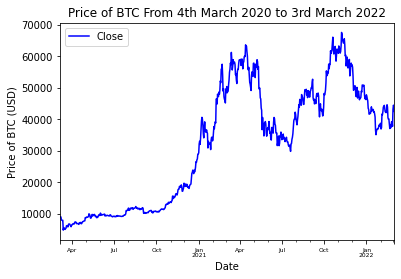

In [17]:
fig = plt.figure(figsize=(20,10))
ax  = overall_df.plot(x = 'Time',y = 'Close', style = 'b-')
plt.xlabel('Date')
plt.xticks(fontsize=6 ) 
plt.ylabel('Price of BTC (USD)')
plt.title("Price of BTC From 4th March 2020 to 3rd March 2022")

In [18]:
print(overall_df.isna().sum())
overall_df.to_csv('../data/dataset.csv', index=False)

Time                       0
Compound                   0
Close                      0
Volume                     0
FundingRate                0
Bitcoin_SVI                0
Cryptocurrency_SVI         0
No. of Active Addresses    0
No. of Unique Addresses    2
Transactions               0
dtype: int64


In [19]:
lag_cols = list(overall_df.columns)[1:]
merging_keys = ['Time']

In [20]:
lag_cols

['Compound',
 'Close',
 'Volume',
 'FundingRate',
 'Bitcoin_SVI',
 'Cryptocurrency_SVI',
 'No. of Active Addresses',
 'No. of Unique Addresses',
 'Transactions']

In [21]:
shift_range = [x+1 for x in range(N)]

for i in range(len(shift_range)):
    shift = shift_range[i]
    train_shift = overall_df[merging_keys + lag_cols].copy()
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    overall_df = pd.merge(overall_df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
    
del train_shift

overall_df = overall_df[N:]
    
overall_df.head()

,Time,Compound,Close,Volume,FundingRate,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions,...,Transactions_lag_4,Compound_lag_5,Close_lag_5,Volume_lag_5,FundingRate_lag_5,Bitcoin_SVI_lag_5,Cryptocurrency_SVI_lag_5,No. of Active Addresses_lag_5,No. of Unique Addresses_lag_5,Transactions_lag_5
5,2020-03-09 00:00:00,0.33916,7931.3,20704818.48,0.02,16.05,5.16,809850,606002.0,348211.0,...,348211.0,0.33916,7931.3,20704818.48,0.02,16.05,5.16,809850,606002.0,348211.0
6,2020-03-10 00:00:00,0.33916,7895.3,13650591.37,0.01,12.34,4.44,807778,601526.0,329698.0,...,329698.0,0.33916,7895.3,13650591.37,0.01,12.34,4.44,807778,601526.0,329698.0
7,2020-03-11 00:00:00,0.33916,7933.2,11450174.16,0.01,10.49,4.23,728889,528053.0,287492.0,...,287492.0,0.33916,7933.2,11450174.16,0.01,10.49,4.23,728889,528053.0,287492.0
8,2020-03-12 00:00:00,0.0772,4802.9,55248355.79,0.013333,22.83,6.2,909601,653156.0,349978.0,...,349978.0,0.0772,4802.9,55248355.79,0.013333,22.83,6.2,909601,653156.0,349978.0
9,2020-03-13 00:00:00,0.33916,5576.3,64233445.37,-0.113333,30.86,6.71,786409,NaN,276798.0,...,276798.0,0.33916,5576.3,64233445.37,-0.113333,30.86,6.71,786409,NaN,276798.0


In [22]:
lag_cols

['Compound',
 'Close',
 'Volume',
 'FundingRate',
 'Bitcoin_SVI',
 'Cryptocurrency_SVI',
 'No. of Active Addresses',
 'No. of Unique Addresses',
 'Transactions']

In [23]:
overall_df = get_mov_avg_std(overall_df, 'Close',N)
overall_df.columns

Index(['Time', 'Compound', 'Close', 'Volume', 'FundingRate', 'Bitcoin_SVI',
       'Cryptocurrency_SVI', 'No. of Active Addresses',
       'No. of Unique Addresses', 'Transactions', 'Compound_lag_1',
       'Close_lag_1', 'Volume_lag_1', 'FundingRate_lag_1', 'Bitcoin_SVI_lag_1',
       'Cryptocurrency_SVI_lag_1', 'No. of Active Addresses_lag_1',
       'No. of Unique Addresses_lag_1', 'Transactions_lag_1', 'Compound_lag_2',
       'Close_lag_2', 'Volume_lag_2', 'FundingRate_lag_2', 'Bitcoin_SVI_lag_2',
       'Cryptocurrency_SVI_lag_2', 'No. of Active Addresses_lag_2',
       'No. of Unique Addresses_lag_2', 'Transactions_lag_2', 'Compound_lag_3',
       'Close_lag_3', 'Volume_lag_3', 'FundingRate_lag_3', 'Bitcoin_SVI_lag_3',
       'Cryptocurrency_SVI_lag_3', 'No. of Active Addresses_lag_3',
       'No. of Unique Addresses_lag_3', 'Transactions_lag_3', 'Compound_lag_4',
       'Close_lag_4', 'Volume_lag_4', 'FundingRate_lag_4', 'Bitcoin_SVI_lag_4',
       'Cryptocurrency_SVI_lag_4', '

In [24]:
overall_df.columns

Index(['Time', 'Compound', 'Close', 'Volume', 'FundingRate', 'Bitcoin_SVI',
       'Cryptocurrency_SVI', 'No. of Active Addresses',
       'No. of Unique Addresses', 'Transactions', 'Compound_lag_1',
       'Close_lag_1', 'Volume_lag_1', 'FundingRate_lag_1', 'Bitcoin_SVI_lag_1',
       'Cryptocurrency_SVI_lag_1', 'No. of Active Addresses_lag_1',
       'No. of Unique Addresses_lag_1', 'Transactions_lag_1', 'Compound_lag_2',
       'Close_lag_2', 'Volume_lag_2', 'FundingRate_lag_2', 'Bitcoin_SVI_lag_2',
       'Cryptocurrency_SVI_lag_2', 'No. of Active Addresses_lag_2',
       'No. of Unique Addresses_lag_2', 'Transactions_lag_2', 'Compound_lag_3',
       'Close_lag_3', 'Volume_lag_3', 'FundingRate_lag_3', 'Bitcoin_SVI_lag_3',
       'Cryptocurrency_SVI_lag_3', 'No. of Active Addresses_lag_3',
       'No. of Unique Addresses_lag_3', 'Transactions_lag_3', 'Compound_lag_4',
       'Close_lag_4', 'Volume_lag_4', 'FundingRate_lag_4', 'Bitcoin_SVI_lag_4',
       'Cryptocurrency_SVI_lag_4', '

# Train-Test Split


In [25]:
num_cv = int(cv_size*len(overall_df))
num_test = int(test_size*len(overall_df))
num_train = len(overall_df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = overall_df[:num_train]
cv = overall_df[num_train:num_train+num_cv]
train_cv = overall_df[:num_train+num_cv]
test = overall_df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 435
num_cv = 145
num_test = 145
train.shape = (435, 57)
cv.shape = (145, 57)
train_cv.shape = (580, 57)
test.shape = (145, 57)


In [26]:
train_time = train['Time']
test_time = test['Time']
cv_time = cv['Time']
train_cv_time = train_cv['Time']

train = train.drop(columns = ['Time'])
test = test.drop(columns = ['Time'])
cv = cv.drop(columns = ['Time'])
train_cv = train_cv.drop(columns = ['Time'])

# Select features, the target output is'Close'
feature_pool = train.columns
#Note : Close is a feature as well 

output = 'Close'

In [27]:
print(feature_pool)

Index(['Compound', 'Close', 'Volume', 'FundingRate', 'Bitcoin_SVI',
       'Cryptocurrency_SVI', 'No. of Active Addresses',
       'No. of Unique Addresses', 'Transactions', 'Compound_lag_1',
       'Close_lag_1', 'Volume_lag_1', 'FundingRate_lag_1', 'Bitcoin_SVI_lag_1',
       'Cryptocurrency_SVI_lag_1', 'No. of Active Addresses_lag_1',
       'No. of Unique Addresses_lag_1', 'Transactions_lag_1', 'Compound_lag_2',
       'Close_lag_2', 'Volume_lag_2', 'FundingRate_lag_2', 'Bitcoin_SVI_lag_2',
       'Cryptocurrency_SVI_lag_2', 'No. of Active Addresses_lag_2',
       'No. of Unique Addresses_lag_2', 'Transactions_lag_2', 'Compound_lag_3',
       'Close_lag_3', 'Volume_lag_3', 'FundingRate_lag_3', 'Bitcoin_SVI_lag_3',
       'Cryptocurrency_SVI_lag_3', 'No. of Active Addresses_lag_3',
       'No. of Unique Addresses_lag_3', 'Transactions_lag_3', 'Compound_lag_4',
       'Close_lag_4', 'Volume_lag_4', 'FundingRate_lag_4', 'Bitcoin_SVI_lag_4',
       'Cryptocurrency_SVI_lag_4', 'No. of A

### NaN Values

In [28]:
print(train.isna().sum())
print(test.isna().sum())
print(cv.isna().sum())
print(train_cv.isna().sum())

Compound                         0
Close                            0
Volume                           0
FundingRate                      0
Bitcoin_SVI                      0
Cryptocurrency_SVI               0
No. of Active Addresses          0
No. of Unique Addresses          2
Transactions                     0
Compound_lag_1                   0
Close_lag_1                      0
Volume_lag_1                     0
FundingRate_lag_1                0
Bitcoin_SVI_lag_1                0
Cryptocurrency_SVI_lag_1         0
No. of Active Addresses_lag_1    0
No. of Unique Addresses_lag_1    2
Transactions_lag_1               0
Compound_lag_2                   0
Close_lag_2                      0
Volume_lag_2                     0
FundingRate_lag_2                0
Bitcoin_SVI_lag_2                0
Cryptocurrency_SVI_lag_2         0
No. of Active Addresses_lag_2    0
No. of Unique Addresses_lag_2    2
Transactions_lag_2               0
Compound_lag_3                   0
Close_lag_3         

In [29]:

train

,Compound,Close,Volume,FundingRate,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions,Compound_lag_1,...,Close_lag_5,Volume_lag_5,FundingRate_lag_5,Bitcoin_SVI_lag_5,Cryptocurrency_SVI_lag_5,No. of Active Addresses_lag_5,No. of Unique Addresses_lag_5,Transactions_lag_5,Close_mean,Close_std
5,0.33916,7931.3,20704818.48,0.02,16.05,5.16,809850,606002.0,348211.0,0.33916,...,7931.3,20704818.48,0.02,16.05,5.16,809850,606002.0,348211.0,NaN,NaN
6,0.33916,7895.3,13650591.37,0.01,12.34,4.44,807778,601526.0,329698.0,0.33916,...,7895.3,13650591.37,0.01,12.34,4.44,807778,601526.0,329698.0,7931.300000,NaN
7,0.33916,7933.2,11450174.16,0.01,10.49,4.23,728889,528053.0,287492.0,0.33916,...,7933.2,11450174.16,0.01,10.49,4.23,728889,528053.0,287492.0,7913.300000,25.455844
8,0.0772,4802.9,55248355.79,0.013333,22.83,6.2,909601,653156.0,349978.0,0.0772,...,4802.9,55248355.79,0.013333,22.83,6.2,909601,653156.0,349978.0,7919.933333,21.354235
9,0.33916,5576.3,64233445.37,-0.113333,30.86,6.71,786409,NaN,276798.0,0.33916,...,5576.3,64233445.37,-0.113333,30.86,6.71,786409,NaN,276798.0,7140.675000,1558.614193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,0.417171,49675.4,497271871.0,0.02,53.49,62.84,1187747,806882.0,276472.0,0.417171,...,49675.4,497271871.0,0.02,53.49,62.84,1187747,806882.0,276472.0,55853.340000,3668.095303
436,0.071533,49848.5,273449532.7,0.033333,33.04,52.22,1066269,752353.0,266055.0,0.071533,...,49848.5,273449532.7,0.033333,33.04,52.22,1066269,752353.0,266055.0,54015.800000,4063.410321
437,0.40982,46775.4,379327493.4,0.013333,25.96,51.34,953308,646899.0,232099.0,0.40982,...,46775.4,379327493.4,0.013333,25.96,51.34,953308,646899.0,232099.0,52335.460000,3583.425285
438,0.417171,46427.4,442072367.4,0.026667,36.0,57.0,971649,604353.0,219435.0,0.417171,...,46427.4,442072367.4,0.026667,36.0,57.0,971649,604353.0,219435.0,50527.900000,3669.024837


In [30]:

KNN_miss_filling = KNNImputer(n_neighbors=5).fit(train)
train = pd.DataFrame(KNN_miss_filling.transform(train))

KNN_miss_filling = KNNImputer(n_neighbors=5).fit(test)
test = pd.DataFrame(KNN_miss_filling.transform(test))

KNN_miss_filling = KNNImputer(n_neighbors=5).fit(train_cv)
train_cv = pd.DataFrame(KNN_miss_filling.transform(train_cv))

KNN_miss_filling = KNNImputer(n_neighbors=5).fit(cv)
cv = pd.DataFrame(KNN_miss_filling.transform(cv))



In [31]:
train.columns = feature_pool
test.columns = feature_pool
train_cv.columns = feature_pool
cv.columns = feature_pool

In [32]:
print(train.isna().sum())
print(test.isna().sum())
print(cv.isna().sum())
print(train_cv.isna().sum())

Compound                         0
Close                            0
Volume                           0
FundingRate                      0
Bitcoin_SVI                      0
Cryptocurrency_SVI               0
No. of Active Addresses          0
No. of Unique Addresses          0
Transactions                     0
Compound_lag_1                   0
Close_lag_1                      0
Volume_lag_1                     0
FundingRate_lag_1                0
Bitcoin_SVI_lag_1                0
Cryptocurrency_SVI_lag_1         0
No. of Active Addresses_lag_1    0
No. of Unique Addresses_lag_1    0
Transactions_lag_1               0
Compound_lag_2                   0
Close_lag_2                      0
Volume_lag_2                     0
FundingRate_lag_2                0
Bitcoin_SVI_lag_2                0
Cryptocurrency_SVI_lag_2         0
No. of Active Addresses_lag_2    0
No. of Unique Addresses_lag_2    0
Transactions_lag_2               0
Compound_lag_3                   0
Close_lag_3         

## Scale the train, dev and test set

In [33]:
# Standardized features:
standardized_features = ['Compound','Volume', 'Close', 'Close_mean', 'Close_std', 'Transactions', 'Cryptocurrency_SVI', 'Bitcoin_SVI','No. of Active Addresses', 'No. of Unique Addresses']     
for i in range(len(lag_cols)): 
    for j in range(1, N+1):
        standardized_features.append(lag_cols[i]+"_lag_"+ str(j))
non_standardized_features = list(set(train.columns)-set(standardized_features))
non_standardized_features



['FundingRate']

In [34]:
# Get the scaler based on train set
scaler = preprocessing.StandardScaler().fit(train[standardized_features])
print('The mean and variance of training set:', scaler.mean_, scaler.var_)

train_std=pd.DataFrame(scaler.fit_transform(train[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
train_nstd=pd.DataFrame(train[non_standardized_features])


train_std.columns = train_std.columns.map(lambda x: standardized_features[x])
train_std.reset_index(drop=True, inplace=True)
train_nstd.reset_index(drop=True, inplace=True)
train_scaled = pd.concat([train_std,train_nstd], sort=False,axis=1)

# Get the scaler based on cv set
scaler.cv = preprocessing.StandardScaler().fit(cv[standardized_features])
print('The mean and variance of cv set:', scaler.cv.mean_, scaler.cv.var_)


cv_std=pd.DataFrame(scaler.transform(cv[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
cv_nstd=pd.DataFrame(cv[non_standardized_features])
cv_std.columns = cv_std.columns.map(lambda x: standardized_features[x])
cv_std.reset_index(drop=True, inplace=True)
cv_nstd.reset_index(drop=True, inplace=True)
cv_scaled = pd.concat([cv_std,cv_nstd], sort=False,axis=1)


scaler_traincv = preprocessing.StandardScaler().fit(train_cv[standardized_features])
print('The mean and variance of training cv set:', scaler_traincv.mean_, scaler_traincv.var_)


train_cv_std=pd.DataFrame(scaler.transform(train_cv[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
train_cv_nstd=pd.DataFrame(train_cv[non_standardized_features])
train_cv_std.columns = train_cv_std.columns.map(lambda x: standardized_features[x])
train_cv_std.reset_index(drop=True, inplace=True)
train_cv_nstd.reset_index(drop=True, inplace=True)
train_cv_scaled = pd.concat([train_cv_std,train_cv_nstd], sort=False,axis=1)



scaler_test = preprocessing.StandardScaler().fit(test[standardized_features])
print('The mean and variance of test set:', scaler_test.mean_, scaler_test.var_)


test_std=pd.DataFrame(scaler.transform(test[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
test_nstd=pd.DataFrame(test[non_standardized_features])
test_std.columns = test_std.columns.map(lambda x: standardized_features[x])
test_std.reset_index(drop=True, inplace=True)
test_nstd.reset_index(drop=True, inplace=True)
test_scaled = pd.concat([test_std,test_nstd], sort=False,axis=1)



The mean and variance of training set: [2.41025156e-01 9.81899260e+07 2.33389349e+04 2.30778245e+04
 8.25461957e+02 3.04091101e+05 1.29212874e+01 1.25677701e+01
 9.95913864e+05 6.82013597e+05 2.41025156e-01 2.41025156e-01
 2.41025156e-01 2.41025156e-01 2.41025156e-01 2.33389349e+04
 2.33389349e+04 2.33389349e+04 2.33389349e+04 2.33389349e+04
 9.81899260e+07 9.81899260e+07 9.81899260e+07 9.81899260e+07
 9.81899260e+07 2.53946360e-02 2.53946360e-02 2.53946360e-02
 2.53946360e-02 2.53946360e-02 1.25677701e+01 1.25677701e+01
 1.25677701e+01 1.25677701e+01 1.25677701e+01 1.29212874e+01
 1.29212874e+01 1.29212874e+01 1.29212874e+01 1.29212874e+01
 9.95913864e+05 9.95913864e+05 9.95913864e+05 9.95913864e+05
 9.95913864e+05 6.82013597e+05 6.82013597e+05 6.82013597e+05
 6.82013597e+05 6.82013597e+05 3.04091101e+05 3.04091101e+05
 3.04091101e+05 3.04091101e+05 3.04091101e+05] [3.62373247e-02 1.37847719e+16 3.42852453e+08 3.39486279e+08
 8.34180056e+05 1.20922709e+09 2.26477029e+02 9.32651015e+01

In [35]:
# Update the order within feature pool
feature_pool = list(train.columns)[9:]

feature_pool

['Compound_lag_1',
 'Close_lag_1',
 'Volume_lag_1',
 'FundingRate_lag_1',
 'Bitcoin_SVI_lag_1',
 'Cryptocurrency_SVI_lag_1',
 'No. of Active Addresses_lag_1',
 'No. of Unique Addresses_lag_1',
 'Transactions_lag_1',
 'Compound_lag_2',
 'Close_lag_2',
 'Volume_lag_2',
 'FundingRate_lag_2',
 'Bitcoin_SVI_lag_2',
 'Cryptocurrency_SVI_lag_2',
 'No. of Active Addresses_lag_2',
 'No. of Unique Addresses_lag_2',
 'Transactions_lag_2',
 'Compound_lag_3',
 'Close_lag_3',
 'Volume_lag_3',
 'FundingRate_lag_3',
 'Bitcoin_SVI_lag_3',
 'Cryptocurrency_SVI_lag_3',
 'No. of Active Addresses_lag_3',
 'No. of Unique Addresses_lag_3',
 'Transactions_lag_3',
 'Compound_lag_4',
 'Close_lag_4',
 'Volume_lag_4',
 'FundingRate_lag_4',
 'Bitcoin_SVI_lag_4',
 'Cryptocurrency_SVI_lag_4',
 'No. of Active Addresses_lag_4',
 'No. of Unique Addresses_lag_4',
 'Transactions_lag_4',
 'Compound_lag_5',
 'Close_lag_5',
 'Volume_lag_5',
 'FundingRate_lag_5',
 'Bitcoin_SVI_lag_5',
 'Cryptocurrency_SVI_lag_5',
 'No. of Ac

## Split into X and y

In [36]:
X_train = train[feature_pool]
y_train = train[output]
X_cv = cv[feature_pool]
y_cv = cv[output]
X_train_cv = train_cv[feature_pool]
y_train_cv = train_cv[output]
X_test = test[feature_pool]
y_test = test[output]
print(feature_pool)
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_test.shape))
print("y_sample.shape = " + str(y_test.shape))

['Compound_lag_1', 'Close_lag_1', 'Volume_lag_1', 'FundingRate_lag_1', 'Bitcoin_SVI_lag_1', 'Cryptocurrency_SVI_lag_1', 'No. of Active Addresses_lag_1', 'No. of Unique Addresses_lag_1', 'Transactions_lag_1', 'Compound_lag_2', 'Close_lag_2', 'Volume_lag_2', 'FundingRate_lag_2', 'Bitcoin_SVI_lag_2', 'Cryptocurrency_SVI_lag_2', 'No. of Active Addresses_lag_2', 'No. of Unique Addresses_lag_2', 'Transactions_lag_2', 'Compound_lag_3', 'Close_lag_3', 'Volume_lag_3', 'FundingRate_lag_3', 'Bitcoin_SVI_lag_3', 'Cryptocurrency_SVI_lag_3', 'No. of Active Addresses_lag_3', 'No. of Unique Addresses_lag_3', 'Transactions_lag_3', 'Compound_lag_4', 'Close_lag_4', 'Volume_lag_4', 'FundingRate_lag_4', 'Bitcoin_SVI_lag_4', 'Cryptocurrency_SVI_lag_4', 'No. of Active Addresses_lag_4', 'No. of Unique Addresses_lag_4', 'Transactions_lag_4', 'Compound_lag_5', 'Close_lag_5', 'Volume_lag_5', 'FundingRate_lag_5', 'Bitcoin_SVI_lag_5', 'Cryptocurrency_SVI_lag_5', 'No. of Active Addresses_lag_5', 'No. of Unique Addr

In [37]:
X_train_scaled = train_scaled[feature_pool]
y_train_scaled = train_scaled['Close']
X_cv_scaled = cv_scaled[feature_pool]
X_train_cv_scaled = train_cv_scaled[feature_pool]
y_train_cv_scaled = train_cv_scaled['Close']
X_test_scaled = test_scaled[feature_pool]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_test_scaled.shape = " + str(X_test_scaled.shape))

X_train_scaled.shape = (435, 47)
y_train_scaled.shape = (435,)
X_cv_scaled.shape = (145, 47)
X_train_cv_scaled.shape = (580, 47)
y_train_cv_scaled.shape = (580,)
X_test_scaled.shape = (145, 47)


# Outlier Detection

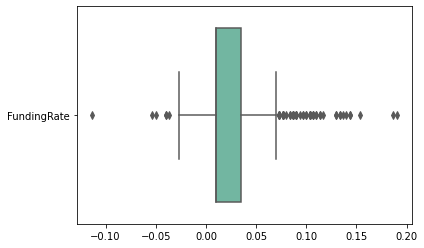

In [38]:
feature_Boxplot1 = ['FundingRate']
feature_Boxplot2 = ['No. of Active Addresses']
feature_Boxplot3 = ['No. of Unique Addresses']
feature_Boxplot4 = ['Transactions']
ax1 = sns.boxplot(data=train[feature_Boxplot1], orient="h", palette="Set2")

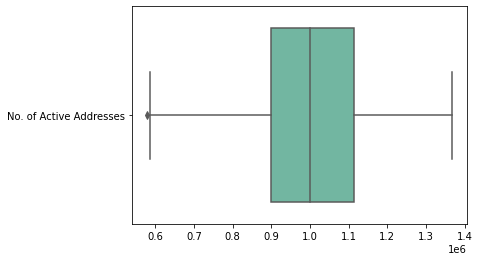

In [39]:
ax2 = sns.boxplot(data=train[feature_Boxplot2], orient="h", palette="Set2")

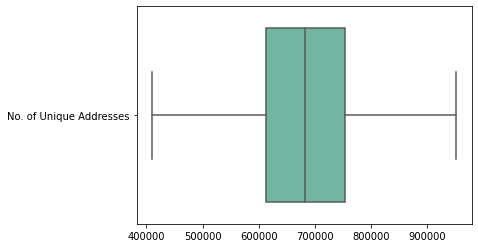

In [40]:
ax3 = sns.boxplot(data=train[feature_Boxplot3], orient="h", palette="Set2")

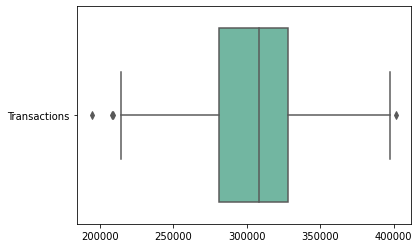

In [41]:
ax4 = sns.boxplot(data=train[feature_Boxplot4], orient="h", palette="Set2")

## EDA

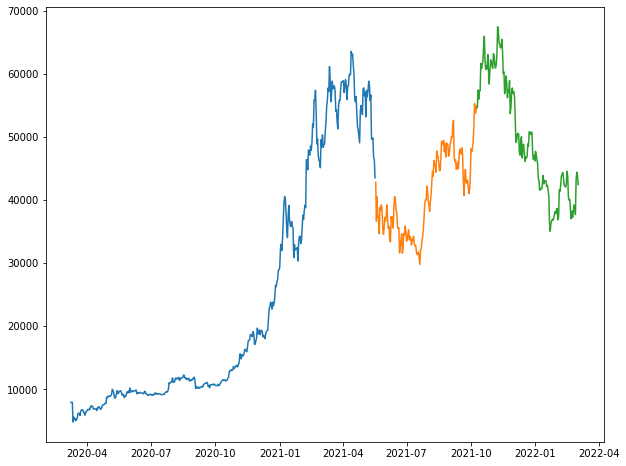

In [42]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

plt.plot(train_time, train['Close'])
plt.plot(cv_time, cv['Close'])
plt.plot(test_time, test['Close'])
plt.show()

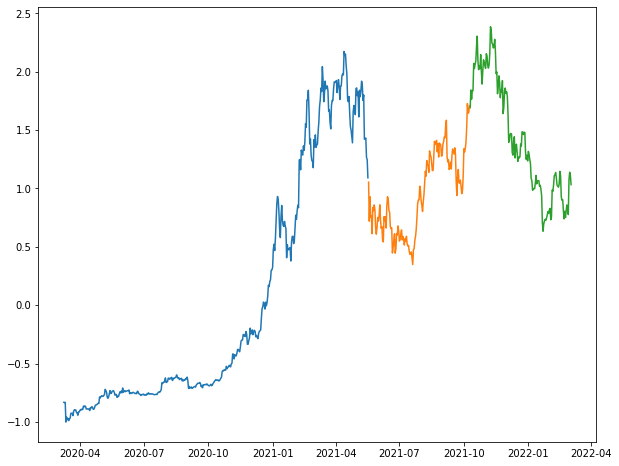

In [43]:
plt.plot(train_time, train_scaled['Close'])
plt.plot(cv_time, cv_scaled['Close'])
plt.plot(test_time, test_scaled['Close'])
plt.show()

# Identifying Correlations 

<Figure size 1440x576 with 0 Axes>

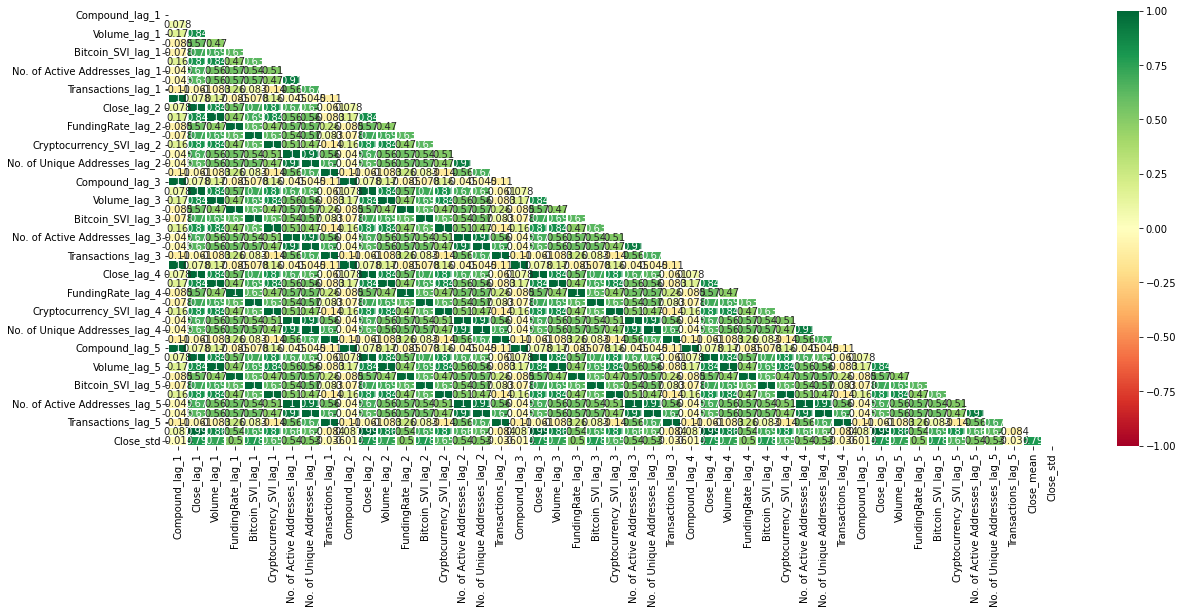

In [44]:
cols = X_train.columns 
corr = X_train[cols].corr()
plt.figure(figsize=(20,8))
plt.figure(figsize=(20,8))
#returns an array of given shape and type as given array, with zeros
mask = np.zeros_like(corr)

# Return the indices for the upper-triangle of arr and makes it true
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=1.5,annot = True)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()